In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import os
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
import torch
torch.cuda.empty_cache()
print("Cleared CUDA memory")
from google.colab import drive
import torch
drive.mount('/content/drive', force_remount=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")


Using device: cpu
Cleared CUDA memory
Mounted at /content/drive
Running on: cpu


In [ ]:
# ─── Block 2: Dataset & DataLoader ───

import os
import numpy as np
from osgeo import gdal
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, InterpolationMode


color2idx = {
    (30, 30, 30):   0,
    (34, 70, 34):   1,
    (120,50, 20):   2,
    (100,100,40):   3,
    (200,180,130):  4,
    (210,150,100):  5,
    (150,200,255):  6
}

# 2.2) Transforms
def multispectral_transform(img: np.ndarray) -> torch.Tensor:
    mn, mx = img.min(), img.max()
    norm = (img - mn) / (mx - mn + 1e-8)
    t = torch.from_numpy(norm.astype(np.float32)).permute(2,0,1)
    return t

resize_img  = Resize((256,256), interpolation=InterpolationMode.BILINEAR)
resize_mask = Resize((256,256), interpolation=InterpolationMode.NEAREST)

# 2.3) Dataset
class GeoTIFFDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_files  = sorted(f for f in os.listdir(img_dir) if f.endswith('.tif'))
        self.mask_files = sorted(f for f in os.listdir(mask_dir) if f.endswith('.tif'))
        self.img_dir    = img_dir
        self.mask_dir   = mask_dir
        self.transform  = transform

    def __len__(self): return len(self.img_files)

    def __getitem__(self, idx):
        # load image & mask
        img_arr  = gdal.Open(os.path.join(self.img_dir,  self.img_files[idx])).ReadAsArray().astype(np.float32)
        mask_arr = gdal.Open(os.path.join(self.mask_dir, self.mask_files[idx])).ReadAsArray().astype(np.int64)

        # image: C×H×W → H×W×C
        img_hwc = np.moveaxis(img_arr, 0, -1)
        img_t   = self.transform(img_hwc) if self.transform else torch.from_numpy(img_hwc).permute(2,0,1)

        # mask: if RGB, map to indices
        if mask_arr.ndim==3 and mask_arr.shape[0]==3:
            m_rgb = np.moveaxis(mask_arr, 0, -1)
            H,W,_ = m_rgb.shape
            idx_map = np.zeros((H,W),dtype=np.int64)
            for rgb,cls in color2idx.items():
                idx_map[np.all(m_rgb==rgb,axis=-1)] = cls
            mask_arr = idx_map
        elif mask_arr.ndim==3:
            mask_arr = mask_arr[0]

        mask_t = torch.from_numpy(mask_arr).long()

        # resize both
        img_t  = resize_img(img_t)
        mask_t = resize_mask(mask_t.unsqueeze(0)).squeeze(0)

        return img_t, mask_t

# 2.4) Build loaders
image_dir = '/content/drive/My Drive/data/raw_labeled_data/images'
mask_dir  = '/content/drive/My Drive/data/raw_labeled_data/annotations'

dataset     = GeoTIFFDataset(image_dir, mask_dir, transform=multispectral_transform)
train_n     = int(0.8 * len(dataset))
val_n       = len(dataset) - train_n
train_ds, val_ds = random_split(dataset, [train_n, val_n])

trainloader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=2)
valloader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=2)

print(f"Train/Val sizes: {len(train_ds)}/{len(val_ds)}")


Train/Val sizes: 7/2


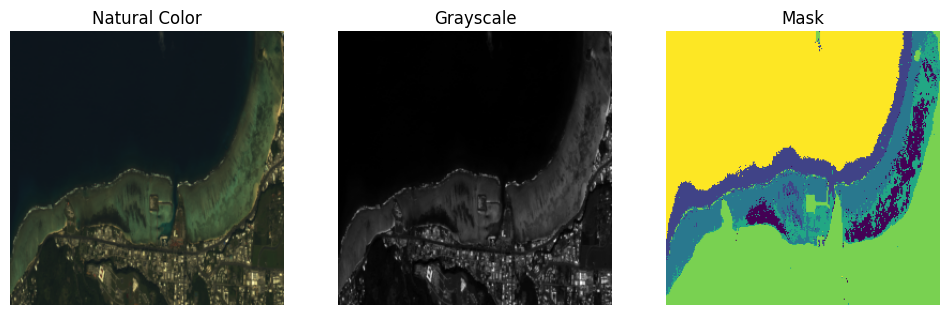

In [ ]:
# ─── Block 3: Sample Visualization ───

import matplotlib.pyplot as plt
import random

def show_sample(ds):
    idx = random.randrange(len(ds))
    img, mask = ds[idx]
    img_np = img.permute(1,2,0).numpy()

    # natural color (4,3,2)
    nc = (img_np[:,:, [3,2,1]] - img_np.min())/(img_np.max()-img_np.min())
    # grayscale
    gs = nc.mean(axis=2)

    fig,axes = plt.subplots(1,3,figsize=(12,4))
    axes[0].imshow((nc*255).astype(np.uint8)); axes[0].set_title("Natural Color"); axes[0].axis('off')
    axes[1].imshow(gs, cmap='gray');            axes[1].set_title("Grayscale");    axes[1].axis('off')
    axes[2].imshow(mask, cmap='viridis');       axes[2].set_title("Mask");         axes[2].axis('off')
    plt.show()

show_sample(dataset)


In [ ]:
# ─── Block 4: Manual Class Weights Override ───

import torch

# 7 classes: [Background, Seagrass, Coral, Macroalgae, Sand, Land, Ocean]
class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], device=device)

print("Using manual class weights:", class_weights.tolist())


Using manual class weights: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Using device: cpu
Epoch 1: Train Loss=1.9666, Train Acc=15.85%, Val Acc=11.41%
→ New best model saved (Val Acc: 11.41%)
Epoch 2: Train Loss=1.7569, Train Acc=30.25%, Val Acc=11.41%
Epoch 3: Train Loss=1.5673, Train Acc=46.27%, Val Acc=11.41%
Epoch 4: Train Loss=1.4163, Train Acc=58.23%, Val Acc=11.41%
Epoch 5: Train Loss=1.2967, Train Acc=65.51%, Val Acc=11.41%
Epoch 6: Train Loss=1.1973, Train Acc=69.53%, Val Acc=11.61%
→ New best model saved (Val Acc: 11.61%)
Epoch 7: Train Loss=1.1158, Train Acc=71.71%, Val Acc=11.04%
Epoch 8: Train Loss=1.0500, Train Acc=73.19%, Val Acc=42.81%
→ New best model saved (Val Acc: 42.81%)
Epoch 9: Train Loss=1.0011, Train Acc=74.28%, Val Acc=40.12%
Epoch 10: Train Loss=0.9651, Train Acc=74.84%, Val Acc=40.13%
Epoch 11: Train Loss=0.9311, Train Acc=75.22%, Val Acc=42.86%
→ New best model saved (Val Acc: 42.86%)
Epoch 12: Train Loss=0.9027, Train Acc=75.49%, Val Acc=60.23%
→ New best model saved (Val Acc: 60.23%)
Epoch 13: Train Loss=0.8805, Train Acc=75.

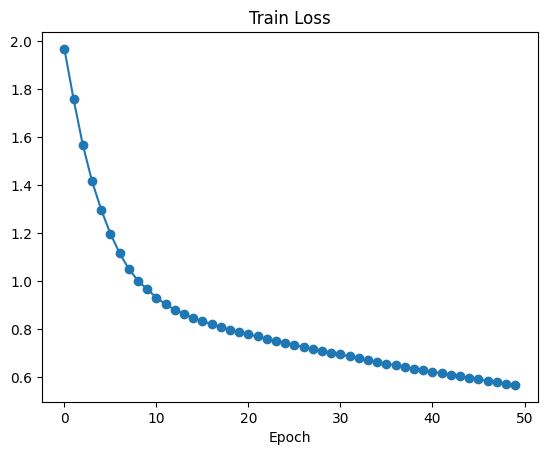

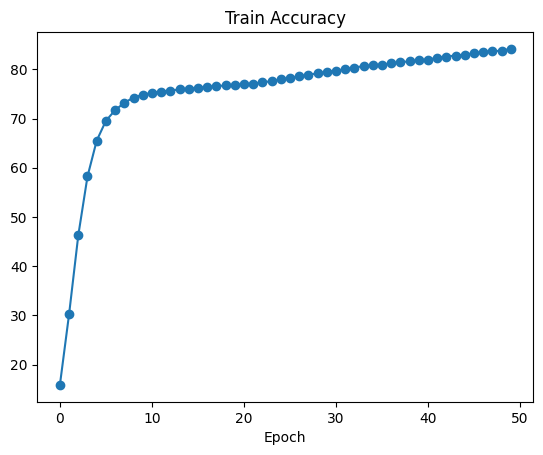

Final model saved to /content/drive/My Drive/trained_custom_cnn.pth


In [ ]:
# ─── Block 5 (CPU‐only): Training Loop without AMP ───

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 1) Paths for saving (define here so they're in scope)
model_save_path      = "/content/drive/My Drive/trained_custom_cnn.pth"
best_model_save_path = "/content/drive/My Drive/best_trained_custom_cnn.pth"
device = torch.device("cpu")
print(f"Using device: {device}")

# 3) Re‐instantiate your CustomCNN on CPU
model = CustomCNN(in_ch=8, n_cls=7).to(device)

# 4) Reduce DataLoader workers for CPU; adjust batch size if needed
trainloader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=0)
valloader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=0)

# 5) Validation helper (same as before)
def validate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            logits = model(imgs)
            preds  = logits.argmax(1)
            correct += (preds == lbls).sum().item()
            total   += lbls.numel()
    model.train()
    return 100 * correct / total

# 6) CPU‐only training loop
def train_model_cpu(model, train_dl, val_dl, epochs=50, lr=5e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    train_losses, train_accs = [], []
    best_val_acc = 0.0

    for epoch in range(1, epochs+1):
        running_loss, correct, total = 0.0, 0, 0
        for batch_idx, (imgs, lbls) in enumerate(train_dl, 1):
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss   = criterion(logits, lbls)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = logits.argmax(1)
            correct += (preds == lbls).sum().item()
            total   += lbls.numel()

            if batch_idx % 10 == 0:
                print(f"Epoch {epoch}/{epochs} | Batch {batch_idx}/{len(train_dl)} | Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_dl)
        epoch_acc  = 100 * correct / total
        val_acc    = validate_model(model, val_dl)

        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        print(f"Epoch {epoch}: Train Loss={epoch_loss:.4f}, Train Acc={epoch_acc:.2f}%, Val Acc={val_acc:.2f}%")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_save_path)
            print(f"→ New best model saved (Val Acc: {best_val_acc:.2f}%)")


    plt.figure(); plt.plot(train_losses, marker='o'); plt.title('Train Loss'); plt.xlabel('Epoch'); plt.show()
    plt.figure(); plt.plot(train_accs,  marker='o'); plt.title('Train Accuracy'); plt.xlabel('Epoch'); plt.show()


    torch.save(model.state_dict(), model_save_path)
    print(f"Final model saved to {model_save_path}")
    return train_losses, train_accs

# 7) Run CPU training
train_losses, train_accs = train_model_cpu(model, trainloader, valloader, epochs=50)


Found all classes in tile: WV02052023.tif
Plotting tile: WV02052023.tif


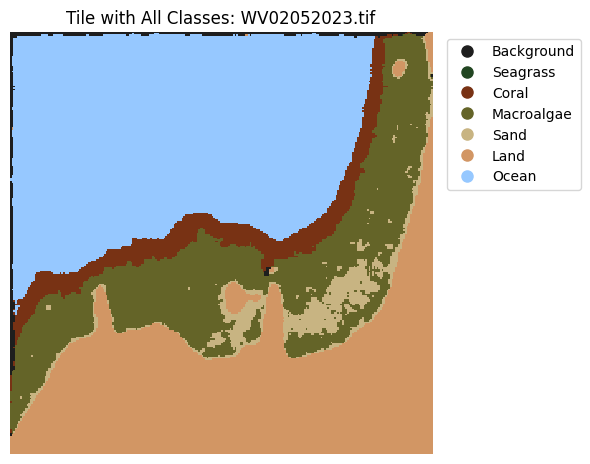

In [ ]:
# ─── Block 6-bis: Find & Plot One Tile with All 7 Classes ───

import os
import numpy as np
import torch
from osgeo import gdal
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def find_tile_with_all_classes(image_dir, model, needed=set(range(7))):
    files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
    for fname in files:
        arr = gdal.Open(os.path.join(image_dir,fname)).ReadAsArray().astype(np.float32)
        hwc = np.moveaxis(arr, 0, -1)
        inp = resize_img(multispectral_transform(hwc)).unsqueeze(0).to(device)

        with torch.no_grad():
            out = model(inp)
            logits = out['out'] if isinstance(out, dict) else out
            pred = logits.argmax(1)[0].cpu().numpy()

        found = set(np.unique(pred))
        if needed.issubset(found):
            print(f"Found all classes in tile: {fname}")
            return pred, fname

    raise RuntimeError("No single tile contained all classes!")

pred, fname = find_tile_with_all_classes(image_dir, model)
print("Plotting tile:", fname)

lbl = median_filter(pred, size=3)
cmap = mcolors.ListedColormap(class_colors)
norm = mcolors.BoundaryNorm(np.arange(-0.5, 7, 1), cmap.N)

plt.figure(figsize=(6,6))
plt.imshow(lbl, cmap=cmap, norm=norm, interpolation='nearest')
plt.title(f"Tile with All Classes: {fname}")
plt.axis('off')

labels = ['Background','Seagrass','Coral','Macroalgae','Sand','Land','Ocean']
patches = [
    plt.Line2D([0],[0], marker='o', color=col, markersize=8, linestyle='', label=l)
    for col,l in zip(class_colors, labels)
]
plt.legend(handles=patches, bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()


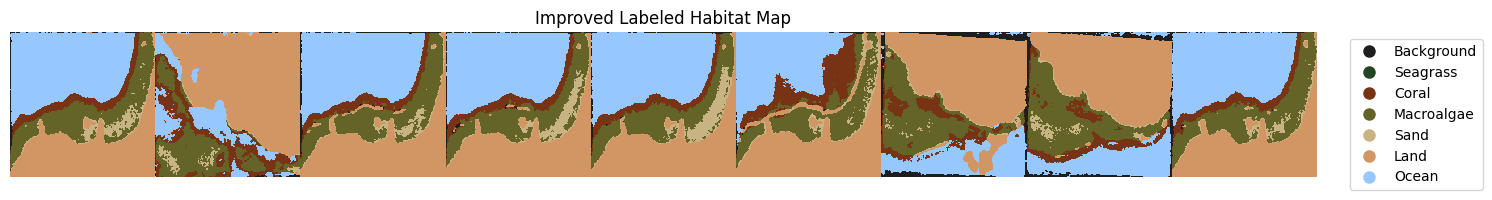

In [ ]:
# ─── Block 7: Full‐Coastline Mosaic (Fixed) ───

import os
import torch
import numpy as np
from osgeo import gdal
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 7.0) Ensure these are in scope from earlier blocks:
# 7.1) Classify each TIFF
all_preds = []
for fname in sorted(os.listdir(image_dir)):
    if not fname.endswith('.tif'):
        continue

    arr = gdal.Open(os.path.join(image_dir, fname)).ReadAsArray().astype(np.float32)
    hwc = np.moveaxis(arr, 0, -1)
    inp = resize_img(multispectral_transform(hwc)).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(inp)

        logits = out['out'] if isinstance(out, dict) else out
        pred   = logits.argmax(dim=1)[0].cpu().numpy()

    all_preds.append(pred)

# 7.2) Stitch predictions horizontally
mosaic = np.hstack([median_filter(p, size=3) for p in all_preds])

# 7.3) Plot mosaic with your custom colormap + legend
cmap = mcolors.ListedColormap(class_colors)
norm = mcolors.BoundaryNorm(np.arange(-0.5, 7, 1), cmap.N)

plt.figure(figsize=(15, 5))
plt.imshow(mosaic, cmap=cmap, norm=norm, interpolation='nearest')
plt.title("Improved Labeled Habitat Map")
plt.axis('off')

labels = ['Background','Seagrass','Coral','Macroalgae','Sand','Land','Ocean']
patches = [
    plt.Line2D([0],[0], marker='o', color=col, markersize=8, linestyle='', label=lab)
    for col, lab in zip(class_colors, labels)
]
plt.legend(handles=patches, bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()
